# Quick Safety Model Test

Run the next cell only. It loads your trained model (`artifacts/model.pth`), evaluates up to 100 random images from `datasets/`, and tests one image from `playground/`.

# Safety Model Evaluation Notebook

Evaluate the binary safety classifier stored in `artifacts/model.pth`, visualize metrics, and test the model on example images.

In [136]:
# 1) Set Paths to Artifacts and Data
from pathlib import Path
import os

# Absolute paths for reliability in VS Code
ARTIFACTS_DIR = Path('/Users/noureddinekamzon/Desktop/Summer2025/AI_Lab/group-1/artifacts')
TEST_DIR = Path('/Users/noureddinekamzon/Desktop/Summer2025/AI_Lab/group-1/datasets')  # expects subfolders 'safe' and 'unsafe'
OUTPUT_DIR = Path('/Users/noureddinekamzon/Desktop/Summer2025/AI_Lab/group-1/artifacts/eval_outputs')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

LABELS_PATH = ARTIFACTS_DIR / 'labels.json'
METRICS_PATH = ARTIFACTS_DIR / 'metrics.json'
MODEL_PATH = ARTIFACTS_DIR / 'model.pth'

assert LABELS_PATH.exists(), f"Missing labels.json at {LABELS_PATH}"
assert MODEL_PATH.exists(), f"Missing model.pth at {MODEL_PATH}"
# metrics.json is optional
print('Artifacts directory:', ARTIFACTS_DIR)
print('Datasets directory:', TEST_DIR)
print('Output directory:', OUTPUT_DIR)

Artifacts directory: /Users/noureddinekamzon/Desktop/Summer2025/AI_Lab/group-1/artifacts
Datasets directory: /Users/noureddinekamzon/Desktop/Summer2025/AI_Lab/group-1/datasets
Output directory: /Users/noureddinekamzon/Desktop/Summer2025/AI_Lab/group-1/artifacts/eval_outputs


In [138]:
# 2) Install and Import Dependencies
import sys
import json
import math
import time
from typing import Tuple, List, Dict

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, roc_auc_score, classification_report
)

print('Python:', sys.version)
print('Torch:', torch.__version__)
print('CUDA available:', torch.cuda.is_available())

Python: 3.12.8 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 10:37:40) [Clang 14.0.6 ]
Torch: 2.5.1
CUDA available: False


In [109]:
# 3) Load Class Labels (labels.json)
with open(LABELS_PATH, 'r') as f:
    label_data = json.load(f)

if 'class_to_idx' in label_data:
    class_to_idx = {k: int(v) for k, v in label_data['class_to_idx'].items()}
elif 'class_names' in label_data:
    class_to_idx = {name: i for i, name in enumerate(label_data['class_names'])}
else:
    raise ValueError('labels.json missing class_to_idx or class_names')

idx_to_class = {v: k for k, v in class_to_idx.items()}
num_classes = len(idx_to_class)
assert len(set(idx_to_class.values())) == num_classes, 'Duplicate class names'
print('Classes:', idx_to_class)
print('num_classes =', num_classes)

Classes: {0: 'safe', 1: 'unsafe'}
num_classes = 2


In [110]:
# 4) Define Model Architecture and Load Weights (model.pth)

# Provided architecture from training
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)  # assumes input images are 224x224
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # [B, 16, 112, 112]
        x = self.pool(F.relu(self.conv2(x)))   # [B, 32, 56, 56]
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Backward-compatible lightweight fallback
class _SimpleSafetyCNN(nn.Module):
    def __init__(self, num_classes: int = 2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.classifier = nn.Linear(64, num_classes)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

# Try versatile loading: TorchScript -> full module -> state_dict (SimpleCNN preferred)

def load_model(model_path: Path, num_classes: int, device: str) -> nn.Module:
    # 1) TorchScript
    try:
        m = torch.jit.load(str(model_path), map_location=device)
        m.eval()
        return m
    except Exception:
        pass
    # 2) Full pickled module
    try:
        obj = torch.load(str(model_path), map_location=device)
        if isinstance(obj, nn.Module):
            obj.eval()
            return obj
    except Exception:
        pass
    # 3) State dict: prefer SimpleCNN -> fallback to _SimpleSafetyCNN
    state = torch.load(str(model_path), map_location=device)
    sd = state.get('state_dict', None) if isinstance(state, dict) else None
    if isinstance(state, dict) and sd is None:
        sd = state
    last_error = None
    # Try SimpleCNN
    try:
        model_sc = SimpleCNN(num_classes=num_classes)
        model_sc.load_state_dict(sd, strict=False)
        model_sc.to(device)
        model_sc.eval()
        return model_sc
    except Exception as e:
        last_error = e
    # Fallback
    try:
        model_fb = _SimpleSafetyCNN(num_classes=num_classes)
        model_fb.load_state_dict(sd, strict=False)
        model_fb.to(device)
        model_fb.eval()
        return model_fb
    except Exception as e2:
        raise RuntimeError(f'Failed to load model from {model_path}: SimpleCNN err={last_error}; Fallback err={e2}')

print('Defined model loader (prefers SimpleCNN).')

Defined model loader (prefers SimpleCNN).


In [111]:
# 5) Select Device and Set Reproducibility

device = 'cuda' if torch.cuda.is_available() else 'cpu'
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print('Using device:', device)
model = load_model(MODEL_PATH, num_classes=num_classes, device=device)
model.to(device)
model.eval()
print('Model loaded to device.')

Using device: cpu
Model loaded to device.


/var/folders/ff/gs8ky77d525b9hwtptsf3xpm0000gn/T/ipykernel_44455/1537717946.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  obj = torch.load(str(model_path), map_locati

In [112]:
# 6) Define Image Preprocessing Transforms

image_size = 224
# Match training: SafetyFilter used Resize -> ToTensor only (no normalization)
APPLY_NORMALIZATION = False  # set True only if your training used normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

if APPLY_NORMALIZATION:
    eval_transform = T.Compose([
        T.Resize((image_size, image_size)),
        T.ToTensor(),
        T.Normalize(mean=mean, std=std),
    ])
    inference_transform = T.Compose([
        T.Resize((image_size, image_size)),
        T.ToTensor(),
        T.Normalize(mean=mean, std=std),
    ])
else:
    eval_transform = T.Compose([
        T.Resize((image_size, image_size)),
        T.ToTensor(),
    ])
    inference_transform = T.Compose([
        T.Resize((image_size, image_size)),
        T.ToTensor(),
    ])

print('Transforms ready. Normalization:', APPLY_NORMALIZATION)

Transforms ready. Normalization: False


In [113]:
# 7) Create Dataset and DataLoader for Evaluation (with sampling)

# Expecting folder structure:
# datasets/
#   safe/
#     00001.jpg ...
#   unsafe/
#     ...

from torch.utils.data import Subset
import random

# How many samples to evaluate (set between 20 and 100 to keep it fast)
MAX_SAMPLES = 1000  # change to 100 if you want more
BALANCED_SAMPLING = True  # try to draw a balanced subset across classes

class ImageFolderWithPaths(ImageFolder):
    def __getitem__(self, index):
        img, label = super().__getitem__(index)
        path = self.samples[index][0]
        return img, label, path

if TEST_DIR.exists():
    base_dataset = ImageFolderWithPaths(root=str(TEST_DIR), transform=eval_transform)
    # Build subset indices
    all_indices = list(range(len(base_dataset)))
    rng = random.Random(seed)

    if BALANCED_SAMPLING and hasattr(base_dataset, 'targets'):
        # Group indices by class
        by_class = {}
        for idx, tgt in enumerate(base_dataset.targets):
            by_class.setdefault(int(tgt), []).append(idx)
        for lst in by_class.values():
            rng.shuffle(lst)
        # Allocate roughly equal per-class samples
        num_classes_ds = len(by_class)
        per_class = max(1, MAX_SAMPLES // max(1, num_classes_ds))
        subset_indices = []
        for cls_idx, idx_list in by_class.items():
            subset_indices.extend(idx_list[:per_class])
        # If we still have room due to rounding, fill randomly
        if len(subset_indices) < MAX_SAMPLES:
            remaining = [i for i in all_indices if i not in set(subset_indices)]
            rng.shuffle(remaining)
            subset_indices.extend(remaining[: MAX_SAMPLES - len(subset_indices)])
        subset_indices = subset_indices[:MAX_SAMPLES]
    else:
        rng.shuffle(all_indices)
        subset_indices = all_indices[:MAX_SAMPLES]

    subset = Subset(base_dataset, subset_indices)

    eval_loader = DataLoader(
        subset,
        batch_size=32,
        shuffle=False,
        num_workers=0,  # important in notebooks/macOS to avoid pickling errors
        pin_memory=torch.cuda.is_available(),
    )
    # Derive readable class names from dataset
    ds_classes = base_dataset.classes
    # Normalize names for alignment and visibility
    ds_classes_norm = [str(c).strip().lower() for c in ds_classes]
    model_classes_ordered = [idx_to_class[i] for i in range(num_classes)]
    model_classes_norm = [str(c).strip().lower() for c in model_classes_ordered]
    print(f'Eval dataset total: {len(base_dataset)} images')
    print('Dataset classes (raw):', ds_classes)
    print('Dataset classes (norm):', ds_classes_norm)
    print('Model classes (by index):', model_classes_ordered)
    print('Model classes (norm):', model_classes_norm)
    print(f'Using sampled subset of {len(subset_indices)} images (balanced={BALANCED_SAMPLING})')
else:
    eval_loader = None
    print('TEST_DIR not found; you can still run single-image/batch inference sections.')

Eval dataset total: 56120 images
Dataset classes (raw): ['safe', 'unsafe']
Dataset classes (norm): ['safe', 'unsafe']
Model classes (by index): ['safe', 'unsafe']
Model classes (norm): ['safe', 'unsafe']
Using sampled subset of 1000 images (balanced=True)


In [114]:
# 8) Evaluation Loop: Predictions, Probabilities, and Top-k (on sampled subset)

def predict_proba(logits: torch.Tensor) -> torch.Tensor:
    # Binary or multi-class softmax
    if logits.ndim == 1:
        logits = logits.unsqueeze(0)
    return torch.softmax(logits, dim=-1)

results_cache = {}

y_true: List[int] = []
y_pred: List[int] = []
y_prob: List[float] = []  # max prob of predicted class
unsafe_prob_list: List[float] = []  # prob assigned to 'unsafe' class
file_paths: List[str] = []

unsafe_idx = class_to_idx.get('unsafe', 1)

if eval_loader is not None:
    model.eval()
    with torch.no_grad():
        for batch in eval_loader:
            # batch may include file paths if using custom dataset
            if len(batch) == 3:
                images, labels, paths = batch
                file_paths.extend(list(paths))
            else:
                images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            logits = model(images)
            probs = predict_proba(logits)
            confs, preds = probs.max(dim=1)

            y_true.extend(labels.detach().cpu().tolist())
            y_pred.extend(preds.detach().cpu().tolist())
            y_prob.extend(confs.detach().cpu().tolist())
            # store unsafe prob specifically
            unsafe_prob_list.extend(probs[:, unsafe_idx].detach().cpu().tolist())

    print('Collected predictions for', len(y_true), 'images')

    # Align dataset label indices (from ImageFolder) to model label indices (from labels.json)
    try:
        ds_classes  # defined in Section 7
        # use normalized names to build mapping
        ds_norm = [str(c).strip().lower() for c in ds_classes]
        model_ordered = [idx_to_class[i] for i in range(num_classes)]
        model_norm = [str(c).strip().lower() for c in model_ordered]
        name_to_model_idx = {name: i for i, name in enumerate(model_norm)}
        ds_idx_to_model_idx = {i: name_to_model_idx.get(nm, i) for i, nm in enumerate(ds_norm)}
        if any(i != j for i, j in ds_idx_to_model_idx.items()):
            y_true = [ds_idx_to_model_idx.get(t, t) for t in y_true]
            print('Aligned y_true indices to model mapping using normalized names:', ds_idx_to_model_idx)
    except NameError:
        # ds_classes not defined; skip alignment
        pass
else:
    print('Skipping dataset evaluation (no TEST_DIR)')

Collected predictions for 1000 images


In [115]:
# 9) Compute Metrics: Accuracy, Precision, Recall, F1, ROC-AUC (mapping-aware)

if y_true:
    # Use mapping-aware predictions if selected in 9d; else raw argmax
    mapping_tag = 'default'
    y_pred_eval = y_pred
    if 'SELECTED_MAPPING' in globals() and SELECTED_MAPPING == 'swapped' and num_classes == 2:
        y_pred_eval = [1 - int(p) for p in y_pred]
        mapping_tag = 'swapped'

    acc = accuracy_score(y_true, y_pred_eval)
    pr, rc, f1, support = precision_recall_fscore_support(y_true, y_pred_eval, average=None, labels=list(idx_to_class.keys()))
    pr_macro, rc_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred_eval, average='macro')
    pr_weighted, rc_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred_eval, average='weighted')

    # ROC-AUC: prefer selected mapping/probabilities when available
    roc_auc = None
    pos_idx = SELECTED_UNSAFE_IDX if 'SELECTED_UNSAFE_IDX' in globals() else class_to_idx.get('unsafe', 1)
    if num_classes == 2 and eval_loader is not None:
        if 'SELECTED_UNSAFE_PROBS' in globals():
            probs_all = list(SELECTED_UNSAFE_PROBS)
            y_true_bin = [1 if t == pos_idx else 0 for t in y_true]
            try:
                roc_auc = roc_auc_score(y_true_bin, probs_all)
            except Exception:
                roc_auc = None
        else:
            probs_all = []
            y_true_bin = []
            with torch.no_grad():
                for batch in eval_loader:
                    if len(batch) == 3:
                        images, labels, _ = batch
                    else:
                        images, labels = batch
                    images = images.to(device)
                    logits = model(images)
                    probs = torch.softmax(logits, dim=-1)[:, pos_idx]
                    probs_all.extend(probs.detach().cpu().tolist())
                    y_true_bin.extend((labels == pos_idx).int().cpu().tolist())
            try:
                roc_auc = roc_auc_score(y_true_bin, probs_all)
            except Exception:
                roc_auc = None

    metrics = {
        'accuracy': float(acc),
        'precision_macro': float(pr_macro),
        'recall_macro': float(rc_macro),
        'f1_macro': float(f1_macro),
        'precision_weighted': float(pr_weighted),
        'recall_weighted': float(rc_weighted),
        'f1_weighted': float(f1_weighted),
        'per_class': {idx_to_class[i]: {'precision': float(pr[i]), 'recall': float(rc[i]), 'f1': float(f1[i]), 'support': int(support[i])} for i in range(num_classes)},
        'roc_auc': None if roc_auc is None else float(roc_auc),
        'mapping': mapping_tag,
    }
    print(json.dumps(metrics, indent=2))
else:
    metrics = None
    print('No dataset metrics (empty y_true)')

{
  "accuracy": 0.676,
  "precision_macro": 0.6760704281712686,
  "recall_macro": 0.676,
  "f1_macro": 0.675967596759676,
  "precision_weighted": 0.6760704281712685,
  "recall_weighted": 0.676,
  "f1_weighted": 0.675967596759676,
  "per_class": {
    "safe": {
      "precision": 0.6795918367346939,
      "recall": 0.666,
      "f1": 0.6727272727272727,
      "support": 500
    },
    "unsafe": {
      "precision": 0.6725490196078432,
      "recall": 0.686,
      "f1": 0.6792079207920793,
      "support": 500
    }
  },
  "roc_auc": 0.706388,
  "mapping": "default"
}


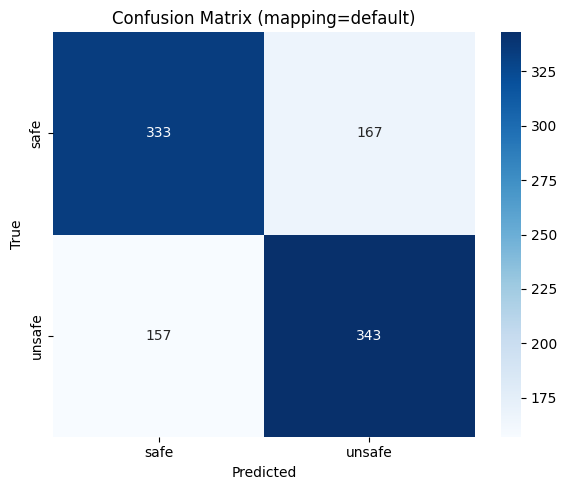

Saved: /Users/noureddinekamzon/Desktop/Summer2025/AI_Lab/group-1/artifacts/eval_outputs/confusion_matrix.png


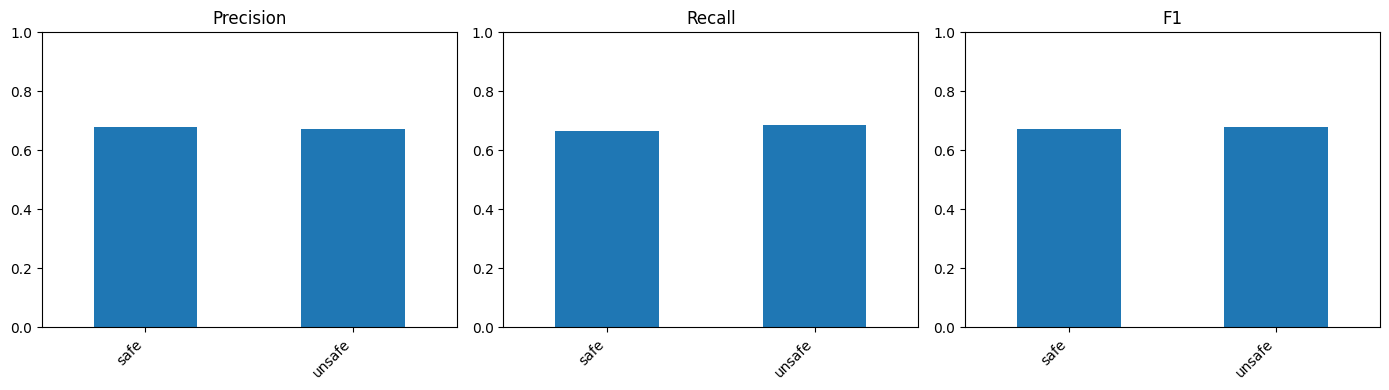

Saved: /Users/noureddinekamzon/Desktop/Summer2025/AI_Lab/group-1/artifacts/eval_outputs/per_class_scores.png


In [116]:
# 10) Plot Confusion Matrix and Per-Class Metrics (mapping-aware)

if y_true:
    y_pred_vis = y_pred
    if 'SELECTED_MAPPING' in globals() and SELECTED_MAPPING == 'swapped' and num_classes == 2:
        y_pred_vis = [1 - int(p) for p in y_pred]
    cm = confusion_matrix(y_true, y_pred_vis, labels=list(range(num_classes)))
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[idx_to_class[i] for i in range(num_classes)], yticklabels=[idx_to_class[i] for i in range(num_classes)])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix (mapping={metrics.get("mapping", "default")})')
    cm_path = OUTPUT_DIR / 'confusion_matrix.png'
    plt.tight_layout()
    plt.savefig(cm_path, dpi=150)
    plt.show()
    print('Saved:', cm_path)

    # Per-class bar charts
    df_scores = pd.DataFrame(metrics['per_class']).T
    fig, axes = plt.subplots(1, 3, figsize=(14,4))
    df_scores['precision'].plot(kind='bar', ax=axes[0], title='Precision')
    df_scores['recall'].plot(kind='bar', ax=axes[1], title='Recall')
    df_scores['f1'].plot(kind='bar', ax=axes[2], title='F1')
    for ax in axes:
        ax.set_ylim(0, 1)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.tight_layout()
    bars_path = OUTPUT_DIR / 'per_class_scores.png'
    plt.savefig(bars_path, dpi=150)
    plt.show()
    print('Saved:', bars_path)
else:
    print('Skipping plots (no dataset results)')

Training metrics: {
  "val_accuracy": 81.29900213827513,
  "epochs": 5,
  "batch_size": 32,
  "learning_rate": 0.001
}


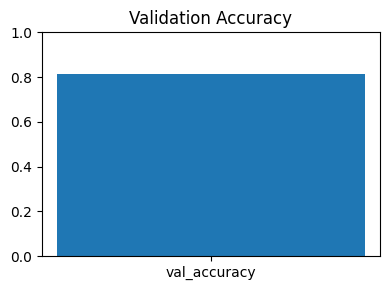

Saved: /Users/noureddinekamzon/Desktop/Summer2025/AI_Lab/group-1/artifacts/eval_outputs/val_accuracy.png


In [117]:
# 11) Load and Visualize Training Metrics (metrics.json)

if METRICS_PATH.exists():
    with open(METRICS_PATH, 'r') as f:
        train_metrics = json.load(f)
    print('Training metrics:', json.dumps(train_metrics, indent=2))

    # If metrics contain per-epoch lists, we can plot them; otherwise just display values
    # Example fallback: plot validation accuracy if present
    val_acc = train_metrics.get('val_accuracy')
    if isinstance(val_acc, (int, float)):
        plt.figure(figsize=(4,3))
        plt.bar(['val_accuracy'], [val_acc/100.0 if val_acc > 1.5 else val_acc])
        plt.ylim(0, 1)
        plt.title('Validation Accuracy')
        plt.tight_layout()
        out_path = OUTPUT_DIR / 'val_accuracy.png'
        plt.savefig(out_path, dpi=150)
        plt.show()
        print('Saved:', out_path)
else:
    print('No training metrics file found at', METRICS_PATH)

Found example images: 11
 11


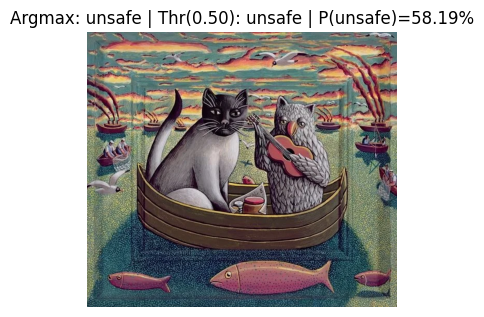

In [118]:
# 12) Single-Image Inference and Visualization (with unsafe prob and mapping-aware label)
from pathlib import Path

# Pull mapping/threshold if computed
try:
    SELECTED_UNSAFE_PROBS
    SINGLE_USE_TH = SELECTED_BEST_TH
    SINGLE_UNSAFE_IDX = SELECTED_UNSAFE_IDX
    SINGLE_SAFE_IDX = 1 - SINGLE_UNSAFE_IDX
except NameError:
    SINGLE_USE_TH = 0.5
    SINGLE_UNSAFE_IDX = class_to_idx.get('unsafe', 1)
    SINGLE_SAFE_IDX = class_to_idx.get('safe', 0)

def run_single_image(image_path: Path) -> Dict[str, object]:
    img = Image.open(image_path).convert('RGB')
    x = inference_transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=-1).squeeze(0)
        unsafe_prob = float(probs[SINGLE_UNSAFE_IDX].item())
        pred_idx_argmax = int(probs.argmax().item())
        # Thresholded label overrides argmax using selected mapping
        pred_idx_thr = SINGLE_UNSAFE_IDX if unsafe_prob >= SINGLE_USE_TH else SINGLE_SAFE_IDX
        label_argmax = idx_to_class[pred_idx_argmax]
        label_thr = idx_to_class[pred_idx_thr]
    fig, ax = plt.subplots(figsize=(4,4))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Argmax: {label_argmax} | Thr({SINGLE_USE_TH:.2f}): {label_thr} | P(unsafe)={unsafe_prob:.2%}')
    plt.show()
    return {'file': str(image_path), 'argmax_label': label_argmax, 'thr_label': label_thr, 'unsafe_prob': unsafe_prob}

# Example: pick an image from playground
PLAYGROUND_DIR = Path('/Users/noureddinekamzon/Desktop/Summer2025/AI_Lab/group-1/playground')
example_images = sorted([p for p in PLAYGROUND_DIR.glob('*') if p.suffix.lower() in {'.jpg', '.jpeg', '.png', '.webp', '.bmp', '.gif', '.tif', '.tiff', '.avif'}])
print('Found example images:', len(example_images))
if example_images:
    _ = run_single_image(example_images[0])

In [119]:
# 13) Batch Inference on a Folder of Images
import itertools

def batch_infer(image_dir: Path, batch_size: int = 32) -> pd.DataFrame:
    paths = [p for p in image_dir.rglob('*') if p.suffix.lower() in {'.jpg', '.jpeg', '.png', '.webp', '.bmp', '.gif', '.tif', '.tiff', '.avif'}]
    records = []
    if not paths:
        return pd.DataFrame(columns=['file', 'pred_label', 'pred_idx', 'conf'])
    for i in range(0, len(paths), batch_size):
        chunk = paths[i:i+batch_size]
        imgs = []
        for p in chunk:
            try:
                img = Image.open(p).convert('RGB')
                imgs.append(inference_transform(img))
            except Exception:
                continue
        if not imgs:
            continue
        x = torch.stack(imgs, dim=0).to(device)
        with torch.no_grad():
            logits = model(x)
            probs = torch.softmax(logits, dim=-1)
            confs, preds = probs.max(dim=1)
        for p, pred, conf in zip(chunk, preds.detach().cpu().tolist(), confs.detach().cpu().tolist()):
            records.append({'file': str(p), 'pred_label': idx_to_class[int(pred)], 'pred_idx': int(pred), 'conf': float(conf)})
    return pd.DataFrame.from_records(records)

# Example: run on playground folder
pred_df = batch_infer(PLAYGROUND_DIR)
print(pred_df.head())
csv_path = OUTPUT_DIR / 'playground_predictions.csv'
pred_df.to_csv(csv_path, index=False)
print('Saved predictions to', csv_path)

                                                file pred_label  pred_idx  \
0  /Users/noureddinekamzon/Desktop/Summer2025/AI_...       safe         0   
1  /Users/noureddinekamzon/Desktop/Summer2025/AI_...       safe         0   
2  /Users/noureddinekamzon/Desktop/Summer2025/AI_...       safe         0   
3  /Users/noureddinekamzon/Desktop/Summer2025/AI_...     unsafe         1   
4  /Users/noureddinekamzon/Desktop/Summer2025/AI_...     unsafe         1   

       conf  
0  0.528886  
1  0.761049  
2  0.586237  
3  0.504353  
4  0.649403  
Saved predictions to /Users/noureddinekamzon/Desktop/Summer2025/AI_Lab/group-1/artifacts/eval_outputs/playground_predictions.csv


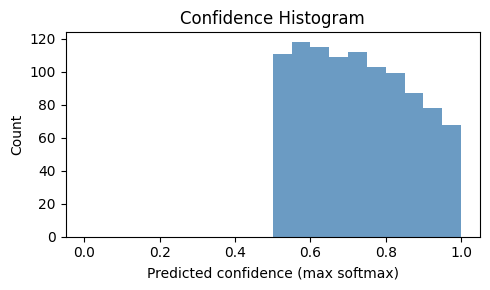

Saved: /Users/noureddinekamzon/Desktop/Summer2025/AI_Lab/group-1/artifacts/eval_outputs/confidence_hist.png


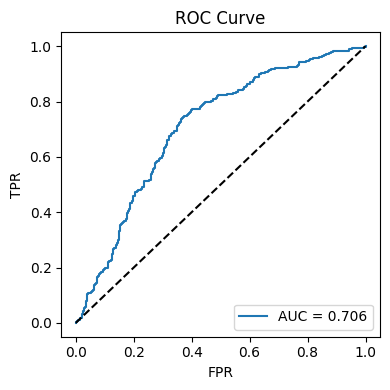

Saved: /Users/noureddinekamzon/Desktop/Summer2025/AI_Lab/group-1/artifacts/eval_outputs/roc_curve.png


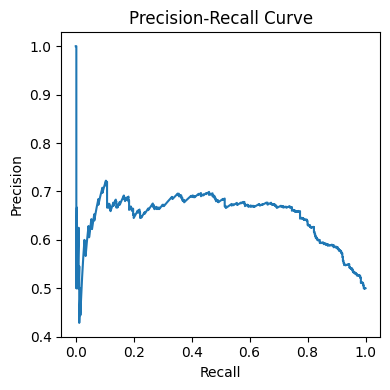

Saved: /Users/noureddinekamzon/Desktop/Summer2025/AI_Lab/group-1/artifacts/eval_outputs/pr_curve.png


In [120]:
# 10b) Probability Histograms and ROC/PR Curves (mapping-aware)
from sklearn.metrics import precision_recall_curve

if y_true:
    # Probability histogram of predicted confidence
    plt.figure(figsize=(5,3))
    plt.hist(y_prob, bins=20, range=(0,1), color='steelblue', alpha=0.8)
    plt.xlabel('Predicted confidence (max softmax)')
    plt.ylabel('Count')
    plt.title('Confidence Histogram')
    hist_path = OUTPUT_DIR / 'confidence_hist.png'
    plt.tight_layout(); plt.savefig(hist_path, dpi=150); plt.show()
    print('Saved:', hist_path)

    if num_classes == 2 and eval_loader is not None:
        # Use selected mapping/probabilities if available
        pos_idx = SELECTED_UNSAFE_IDX if 'SELECTED_UNSAFE_IDX' in globals() else class_to_idx.get('unsafe', 1)
        if 'SELECTED_UNSAFE_PROBS' in globals():
            probs_all = list(SELECTED_UNSAFE_PROBS)
            # y_true already aligned to model indices
            y_true_bin = [1 if t == pos_idx else 0 for t in y_true]
        else:
            probs_all = []
            y_true_bin = []
            with torch.no_grad():
                for batch in eval_loader:
                    images = batch[0].to(device) if isinstance(batch, (list, tuple)) else batch.to(device)
                    labels = batch[1] if isinstance(batch, (list, tuple)) else None
                    logits = model(images)
                    probs = torch.softmax(logits, dim=-1)[:, pos_idx]
                    probs_all.extend(probs.detach().cpu().tolist())
                    if labels is not None:
                        y_true_bin.extend((labels == pos_idx).int().cpu().tolist())
        # ROC curve
        try:
            from sklearn.metrics import roc_curve, auc
            fpr, tpr, _ = roc_curve(y_true_bin, probs_all)
            roc_auc_val = auc(fpr, tpr)
            plt.figure(figsize=(4,4))
            plt.plot(fpr, tpr, label=f'AUC = {roc_auc_val:.3f}')
            plt.plot([0,1], [0,1], 'k--')
            plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend(loc='lower right')
            roc_path = OUTPUT_DIR / 'roc_curve.png'
            plt.tight_layout(); plt.savefig(roc_path, dpi=150); plt.show()
            print('Saved:', roc_path)
        except Exception as e:
            print('ROC curve failed:', e)
        # PR curve
        try:
            precision, recall, _ = precision_recall_curve(y_true_bin, probs_all)
            plt.figure(figsize=(4,4))
            plt.plot(recall, precision)
            plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve')
            pr_path = OUTPUT_DIR / 'pr_curve.png'
            plt.tight_layout(); plt.savefig(pr_path, dpi=150); plt.show()
            print('Saved:', pr_path)
        except Exception as e:
            print('PR curve failed:', e)
else:
    print('Skipping probability plots (no dataset results)')

Misclassified: 324/1000


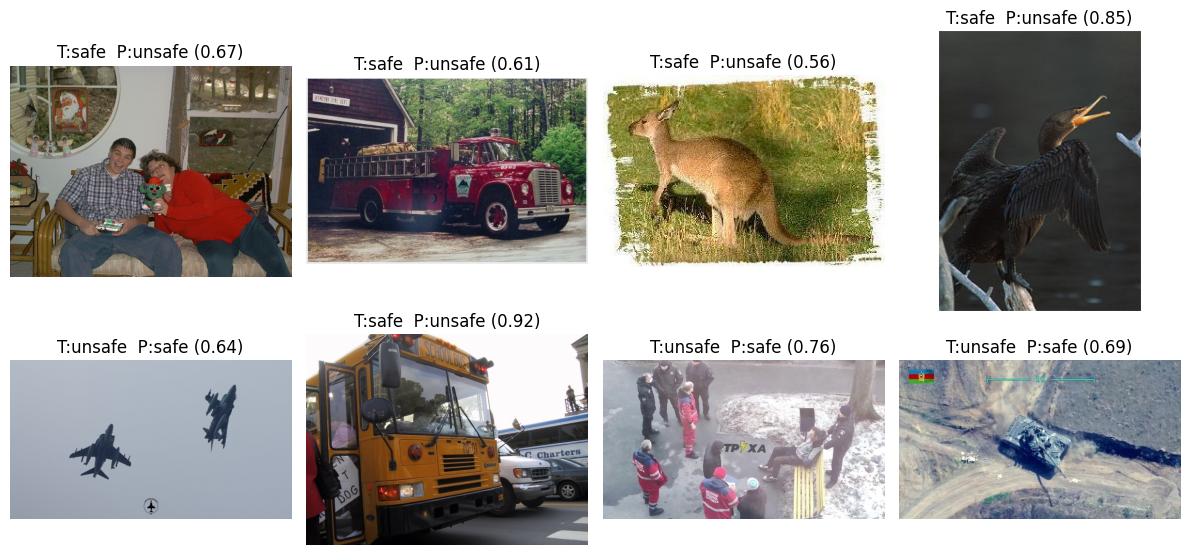

In [121]:
# 14) Error Analysis: Show Misclassified Examples
from math import ceil

if y_true:
    df = pd.DataFrame({
        'true_idx': y_true,
        'pred_idx': y_pred,
        'conf': y_prob,
        'file': file_paths if file_paths else [None]*len(y_true)
    })
    df['true'] = df['true_idx'].map(idx_to_class)
    df['pred'] = df['pred_idx'].map(idx_to_class)
    mis = df[df['true_idx'] != df['pred_idx']]
    print(f'Misclassified: {len(mis)}/{len(df)}')

    def show_grid(rows=2, cols=4, sample_n=8):
        sample = mis.sample(min(sample_n, len(mis)), random_state=seed) if len(mis) else mis
        if sample.empty:
            print('No misclassifications to display.')
            return
        fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
        axes = np.array(axes).reshape(rows, cols)
        for ax, (_, row) in zip(axes.ravel(), sample.iterrows()):
            if row['file'] and Path(row['file']).exists():
                img = Image.open(row['file']).convert('RGB')
                ax.imshow(img)
            ax.axis('off')
            ax.set_title(f"T:{row['true']}  P:{row['pred']} ({row['conf']:.2f})")
        plt.tight_layout(); plt.show()

    show_grid(rows=2, cols=4, sample_n=8)
else:
    print('Skipping error analysis (no dataset results)')

In [122]:
# 15) Export Metrics, Curves, and Predictions (mapping-aware)

if y_true:
    # Save metrics json
    metrics_path = OUTPUT_DIR / 'eval_metrics.json'
    with open(metrics_path, 'w') as f:
        json.dump(metrics if metrics is not None else {}, f, indent=2)
    print('Saved metrics to', metrics_path)

    # Save predictions CSV (with paths if available)
    pred_rows = []
    use_probs = 'SELECTED_UNSAFE_PROBS' in globals()
    export_thr = 'SELECTED_BEST_TH' in globals()
    use_unsafe_idx = SELECTED_UNSAFE_IDX if 'SELECTED_UNSAFE_IDX' in globals() else class_to_idx.get('unsafe', 1)
    use_safe_idx = 1 - use_unsafe_idx
    th_val = SELECTED_BEST_TH if 'SELECTED_BEST_TH' in globals() else (best_th if 'best_th' in globals() else 0.5)

    # Use mapping-aware predicted indices for raw argmax if mapping selected
    y_pred_export = y_pred
    if 'SELECTED_MAPPING' in globals() and SELECTED_MAPPING == 'swapped' and num_classes == 2:
        y_pred_export = [1 - int(p) for p in y_pred]

    for i in range(len(y_true)):
        file_i = file_paths[i] if i < len(file_paths) else None
        raw_pred_idx = y_pred_export[i]
        raw_pred = idx_to_class[raw_pred_idx]
        row = {
            'file': file_i,
            'true': idx_to_class[y_true[i]],
            'raw_pred': raw_pred,
            'raw_pred_idx': raw_pred_idx,
            'conf': y_prob[i],
        }
        # Add mapping-aware fields
        p_unsafe = SELECTED_UNSAFE_PROBS[i] if use_probs else unsafe_prob_list[i]
        row['p_unsafe'] = float(p_unsafe)
        if export_thr:
            thr_idx = use_unsafe_idx if p_unsafe >= th_val else use_safe_idx
            row['thr_pred_idx'] = int(thr_idx)
            row['thr_pred'] = idx_to_class[thr_idx]
            row['thr_threshold'] = float(th_val)
            row['mapping'] = 'selected' if 'SELECTED_MAPPING' in globals() else 'default'
        pred_rows.append(row)

    pred_df = pd.DataFrame(pred_rows)
    pred_csv = OUTPUT_DIR / 'eval_predictions.csv'
    pred_df.to_csv(pred_csv, index=False)
    print('Saved predictions to', pred_csv)
else:
    print('Skipping export (no dataset results)')

Saved metrics to /Users/noureddinekamzon/Desktop/Summer2025/AI_Lab/group-1/artifacts/eval_outputs/eval_metrics.json
Saved predictions to /Users/noureddinekamzon/Desktop/Summer2025/AI_Lab/group-1/artifacts/eval_outputs/eval_predictions.csv


In [123]:
# 16) Optional: Explainability (Grad-CAM) — lightweight version
# This section is optional; it attempts a simple Grad-CAM on the last conv feature map
try:
    import torch.nn.functional as F

    class SimpleGradCAM:
        def __init__(self, model, target_layer):
            self.model = model
            self.target_layer = target_layer
            self.gradients = None
            self.activations = None
            target_layer.register_forward_hook(self._forward_hook)
            target_layer.register_full_backward_hook(self._backward_hook)

        def _forward_hook(self, module, inp, out):
            self.activations = out.detach()
        def _backward_hook(self, module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        def __call__(self, x, class_idx=None):
            self.model.zero_grad()
            logits = self.model(x)
            if class_idx is None:
                class_idx = logits.argmax(dim=1)
            score = logits.gather(1, class_idx.view(-1,1)).squeeze()
            score.backward(torch.ones_like(score))
            weights = self.gradients.mean(dim=(2,3), keepdim=True)
            cam = (weights * self.activations).sum(dim=1, keepdim=True)
            cam = F.relu(cam)
            cam = F.interpolate(cam, size=x.shape[2:], mode='bilinear', align_corners=False)
            cam_min, cam_max = cam.min(), cam.max()
            cam = (cam - cam_min) / (cam_max - cam_min + 1e-6)
            return cam

    # Use last conv layer of our simple CNN
    target_layer = model.features[6] if hasattr(model, 'features') else None
    if target_layer is not None:
        gradcam = SimpleGradCAM(model, target_layer)
        if example_images:
            img = Image.open(example_images[0]).convert('RGB')
            x = inference_transform(img).unsqueeze(0).to(device)
            cam = gradcam(x)
            heat = cam.squeeze(0).squeeze(0).cpu().numpy()
            plt.figure(figsize=(4,4))
            plt.imshow(img)
            plt.imshow(heat, cmap='jet', alpha=0.4)
            plt.axis('off')
            plt.title('Grad-CAM overlay')
            gc_path = OUTPUT_DIR / 'gradcam_overlay.png'
            plt.tight_layout(); plt.savefig(gc_path, dpi=150); plt.show()
            print('Saved:', gc_path)
    else:
        print('Grad-CAM skipped: target layer not found')
except Exception as e:
    print('Grad-CAM section skipped due to error:', e)

Grad-CAM skipped: target layer not found


In [124]:
# 17) Optional: Throughput and Latency Benchmark
import statistics

def benchmark(batch_size=32, iters=5):
    # Use a single image repeated to measure forward pass
    if example_images:
        img = Image.open(example_images[0]).convert('RGB')
        x1 = inference_transform(img)
    else:
        x1 = torch.randn(3, image_size, image_size)
    xs = torch.stack([x1 for _ in range(batch_size)], dim=0).to(device)

    times = []
    model.eval()
    with torch.no_grad():
        # warmup
        for _ in range(2):
            _ = model(xs)
        for _ in range(iters):
            t0 = time.perf_counter()
            _ = model(xs)
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            times.append((time.perf_counter() - t0) * 1000.0)
    avg_ms = statistics.mean(times)
    p95 = np.percentile(times, 95)
    ips = batch_size / (avg_ms / 1000.0)
    return {'batch_size': batch_size, 'iters': iters, 'avg_ms': avg_ms, 'p95_ms': float(p95), 'images_per_sec': ips}

bench = benchmark(batch_size=32, iters=5)
print(json.dumps(bench, indent=2))

{
  "batch_size": 32,
  "iters": 5,
  "avg_ms": 150.88949979981408,
  "p95_ms": 157.66986599192023,
  "images_per_sec": 212.0757245696657
}


Best threshold for unsafe class by F1: th=0.41, F1=0.711


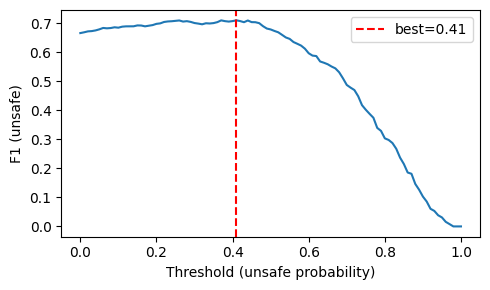

Saved: /Users/noureddinekamzon/Desktop/Summer2025/AI_Lab/group-1/artifacts/eval_outputs/threshold_f1_curve.png
Mean unsafe prob — safe imgs: 0.401 | unsafe imgs: 0.593


In [125]:
# 9b) Calibration & Threshold Tuning for 'unsafe' probability
from sklearn.metrics import f1_score

if y_true and num_classes == 2:
    y_true_bin = [1 if t == unsafe_idx else 0 for t in y_true]
    # Sweep thresholds to maximize F1 for the 'unsafe' class
    thresholds = np.linspace(0.0, 1.0, 101)
    f1s = []
    for th in thresholds:
        preds_bin = [1 if p >= th else 0 for p in unsafe_prob_list]
        f1s.append(f1_score(y_true_bin, preds_bin, zero_division=0))
    best_i = int(np.argmax(f1s))
    best_th = float(thresholds[best_i])
    best_f1 = float(f1s[best_i])
    print(f'Best threshold for unsafe class by F1: th={best_th:.2f}, F1={best_f1:.3f}')

    # Visualize
    plt.figure(figsize=(5,3))
    plt.plot(thresholds, f1s)
    plt.axvline(best_th, color='r', linestyle='--', label=f'best={best_th:.2f}')
    plt.xlabel('Threshold (unsafe probability)')
    plt.ylabel('F1 (unsafe)')
    plt.legend(); plt.tight_layout()
    th_path = OUTPUT_DIR / 'threshold_f1_curve.png'
    plt.savefig(th_path, dpi=150); plt.show()
    print('Saved:', th_path)

    # Check for label inversion symptom: if mean unsafe prob is higher on safe images
    safe_idx = class_to_idx.get('safe', 0)
    safe_probs = [p for p, t in zip(unsafe_prob_list, y_true) if t == safe_idx]
    unsafe_probs = [p for p, t in zip(unsafe_prob_list, y_true) if t == unsafe_idx]
    if safe_probs and unsafe_probs:
        print(f"Mean unsafe prob — safe imgs: {np.mean(safe_probs):.3f} | unsafe imgs: {np.mean(unsafe_probs):.3f}")
else:
    print('Skipping calibration (requires binary classes and dataset results)')

Thresholded metrics (mapping-aware):
{
  "accuracy": 0.676,
  "per_class": {
    "safe": {
      "precision": 0.7315789473684211,
      "recall": 0.556,
      "f1": 0.6318181818181818,
      "support": 500
    },
    "unsafe": {
      "precision": 0.6419354838709678,
      "recall": 0.796,
      "f1": 0.7107142857142857,
      "support": 500
    }
  },
  "threshold": 0.41000000000000003,
  "mapping": "default"
}


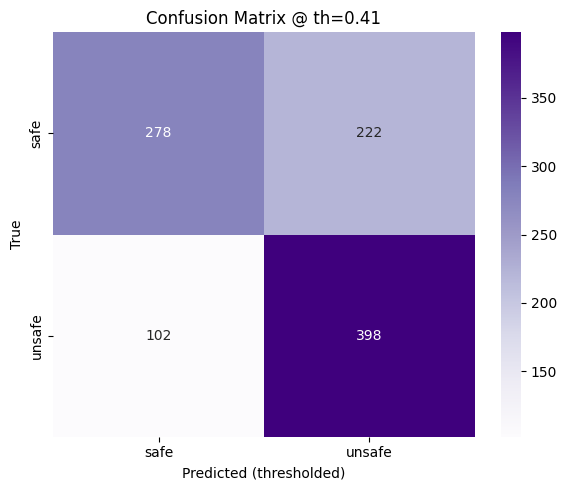

Saved: /Users/noureddinekamzon/Desktop/Summer2025/AI_Lab/group-1/artifacts/eval_outputs/confusion_matrix_threshold_0.41.png


In [126]:
# 9c) Threshold-based predictions and updated metrics (mapping-aware)
if y_true and num_classes == 2:
    # Prefer mapping and threshold selected in 9d; else use 9b; else 0.5
    if 'SELECTED_UNSAFE_PROBS' in globals():
        use_probs = SELECTED_UNSAFE_PROBS
        use_th = SELECTED_BEST_TH
        use_unsafe_idx = SELECTED_UNSAFE_IDX
        use_safe_idx = 1 - use_unsafe_idx
    else:
        use_probs = unsafe_prob_list
        try:
            use_th = best_th
        except NameError:
            use_th = 0.5
        use_unsafe_idx = class_to_idx.get('unsafe', 1)
        use_safe_idx = class_to_idx.get('safe', 0)

    y_pred_thr = [use_unsafe_idx if p >= use_th else use_safe_idx for p in use_probs]

    acc_thr = accuracy_score(y_true, y_pred_thr)
    pr_thr, rc_thr, f1_thr, sup_thr = precision_recall_fscore_support(
        y_true, y_pred_thr, average=None, labels=list(range(num_classes))
    )
    metrics_thr = {
        'accuracy': float(acc_thr),
        'per_class': {idx_to_class[i]: {'precision': float(pr_thr[i]), 'recall': float(rc_thr[i]), 'f1': float(f1_thr[i]), 'support': int(sup_thr[i])} for i in range(num_classes)},
        'threshold': float(use_th),
        'mapping': 'selected' if 'SELECTED_MAPPING' in globals() else 'default'
    }
    print('Thresholded metrics (mapping-aware):')
    print(json.dumps(metrics_thr, indent=2))

    cm_thr = confusion_matrix(y_true, y_pred_thr, labels=list(range(num_classes)))
    plt.figure(figsize=(6,5))
    sns.heatmap(cm_thr, annot=True, fmt='d', cmap='Purples', xticklabels=[idx_to_class[i] for i in range(num_classes)], yticklabels=[idx_to_class[i] for i in range(num_classes)])
    plt.xlabel('Predicted (thresholded)'); plt.ylabel('True'); plt.title(f'Confusion Matrix @ th={use_th:.2f}')
    cm_thr_path = OUTPUT_DIR / f'confusion_matrix_threshold_{use_th:.2f}.png'
    plt.tight_layout(); plt.savefig(cm_thr_path, dpi=150); plt.show()
    print('Saved:', cm_thr_path)
else:
    print('Skipping thresholded metrics (requires binary classes and dataset results)')

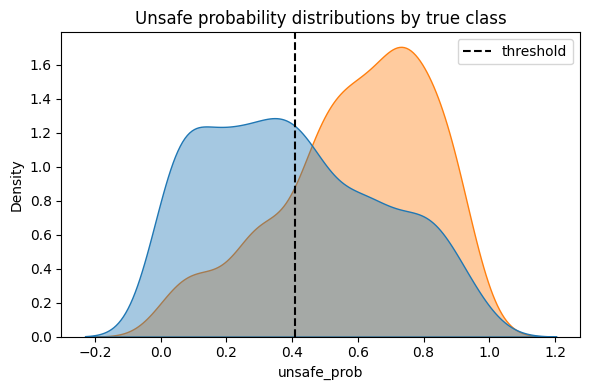

Saved: /Users/noureddinekamzon/Desktop/Summer2025/AI_Lab/group-1/artifacts/eval_outputs/unsafe_prob_distributions.png


In [127]:
# 10c) Distributions of 'unsafe' probabilities by true class
if y_true and num_classes == 2:
    df_probs = pd.DataFrame({
        'unsafe_prob': unsafe_prob_list,
        'true_idx': y_true,
    })
    df_probs['true'] = df_probs['true_idx'].map(idx_to_class)
    plt.figure(figsize=(6,4))
    sns.kdeplot(data=df_probs, x='unsafe_prob', hue='true', fill=True, common_norm=False, alpha=0.4)
    plt.axvline(best_th if 'best_th' in globals() else 0.5, color='k', linestyle='--', label='threshold')
    plt.legend(); plt.title("Unsafe probability distributions by true class")
    dist_path = OUTPUT_DIR / 'unsafe_prob_distributions.png'
    plt.tight_layout(); plt.savefig(dist_path, dpi=150); plt.show()
    print('Saved:', dist_path)
else:
    print('Skipping probability distributions (requires binary classes)')

In [128]:
# 9d) Diagnose possible label inversion and auto-select mapping (with manual override)
FORCE_SWAP = False  # set to True to force swapped mapping regardless of scores

if y_true and num_classes == 2:
    unsafe_idx_orig = unsafe_idx
    unsafe_idx_swap = 1 - unsafe_idx_orig

    # Original mapping metrics (reuse best_th if available)
    try:
        best_th
    except NameError:
        best_th = 0.5
    y_true_bin = [1 if t == unsafe_idx_orig else 0 for t in y_true]
    preds_bin = [1 if p >= best_th else 0 for p in unsafe_prob_list]
    f1_orig = f1_score(y_true_bin, preds_bin, zero_division=0)

    # Swapped mapping: interpret unsafe prob as 1 - p_unsafe
    unsafe_prob_swap = [1.0 - p for p in unsafe_prob_list]
    # Find best threshold under swapped mapping
    thresholds = np.linspace(0.0, 1.0, 101)
    f1s_swap = []
    for th in thresholds:
        preds_bin = [1 if p >= th else 0 for p in unsafe_prob_swap]
        f1s_swap.append(f1_score(y_true_bin, preds_bin, zero_division=0))
    best_i_swap = int(np.argmax(f1s_swap))
    best_th_swap = float(thresholds[best_i_swap])
    f1_swap = float(f1s_swap[best_i_swap])

    print(f'F1 (original mapping @ th={best_th:.2f}): {f1_orig:.3f}')
    print(f'Best F1 (swapped mapping @ th={best_th_swap:.2f}): {f1_swap:.3f}')

    if FORCE_SWAP or f1_swap > f1_orig + 1e-4:
        print('Using swapped interpretation for subsequent analyses.' + (' (forced)' if FORCE_SWAP else ''))
        SELECTED_MAPPING = 'swapped'
        SELECTED_UNSAFE_PROBS = unsafe_prob_swap
        SELECTED_BEST_TH = best_th_swap
        SELECTED_UNSAFE_IDX = unsafe_idx_swap
    else:
        print('Original mapping retained.')
        SELECTED_MAPPING = 'original'
        SELECTED_UNSAFE_PROBS = unsafe_prob_list
        SELECTED_BEST_TH = best_th
        SELECTED_UNSAFE_IDX = unsafe_idx_orig
else:
    print('Skipping label inversion diagnosis (requires binary classes and dataset results)')

F1 (original mapping @ th=0.41): 0.711
Best F1 (swapped mapping @ th=0.00): 0.667
Original mapping retained.


In [129]:
# 9e) Apply selected mapping to raw argmax predictions (for consistency)
if y_true and num_classes == 2:
    # If 9d selected a mapping, compute a mapped version of raw argmax predictions for visibility
    if 'SELECTED_MAPPING' in globals():
        # Determine which class index is "unsafe" under selected mapping
        use_unsafe_idx = SELECTED_UNSAFE_IDX
        use_safe_idx = 1 - use_unsafe_idx
        # Derive argmax-based labels under selected mapping by comparing probs
        # We already have unsafe_prob_list (P(unsafe)); P(safe) = 1 - P(unsafe) for binary softmax
        p_unsafe = SELECTED_UNSAFE_PROBS if 'SELECTED_UNSAFE_PROBS' in globals() else unsafe_prob_list
        y_pred_mapped = [use_unsafe_idx if p >= 0.5 else use_safe_idx for p in p_unsafe]
        cm_mapped = confusion_matrix(y_true, y_pred_mapped, labels=list(range(num_classes)))
        print('Confusion (argmax remapped via selected mapping, th=0.5):\n', cm_mapped)
    else:
        print('No selected mapping from 9d; skipping argmax remap display.')
else:
    print('Skipping mapping application (requires binary classes and dataset results)')

Confusion (argmax remapped via selected mapping, th=0.5):
 [[333 167]
 [157 343]]


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# ------------------------------
# 1. Define same model structure
# ------------------------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)  # 224x224 input assumed
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# ------------------------------
# 2. Load model checkpoint
# ------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint = torch.load(MODEL_PATH, map_location=device)

if "state_dict" in checkpoint:
    state = checkpoint["state_dict"]
else:
    state = checkpoint

# Fix "module." prefix if trained with DataParallel
new_state = {}
for k, v in state.items():
    new_key = k.replace("module.", "") if k.startswith("module.") else k
    new_state[new_key] = v

model = SimpleCNN(num_classes=len(idx_to_class))
model.load_state_dict(new_state, strict=False)
model.to(device).eval()
print("✅ Model loaded on", device)

# ------------------------------
# 3. Dataset + DataLoader
# ------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(str(DATA), transform=transform)
loader = DataLoader(dataset, batch_size=64, shuffle=False)

# ------------------------------
# 4. Evaluation loop
# ------------------------------
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        probs = F.softmax(outputs, dim=1)
        preds = probs.argmax(dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())  # prob for "unsafe"

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# ------------------------------
# 5. Metrics
# ------------------------------
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=dataset.classes))

acc = (all_preds == all_labels).mean()
print(f"Overall Accuracy: {acc:.3f}")

# ------------------------------
# 6. Confusion Matrix Plot
# ------------------------------
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ------------------------------
# 7. ROC Curve
# ------------------------------
fpr, tpr, _ = roc_curve(all_labels, all_probs, pos_label=dataset.class_to_idx['unsafe'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


✅ Model loaded on cpu
Image: car2.jpg
Predicted: safe
Probabilities: {'safe': 0.5288863778114319, 'unsafe': 0.47111356258392334}


/var/folders/ff/gs8ky77d525b9hwtptsf3xpm0000gn/T/ipykernel_44455/2037997120.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(MODEL_PATH, map_location=